In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]


Visualization of some of the training images

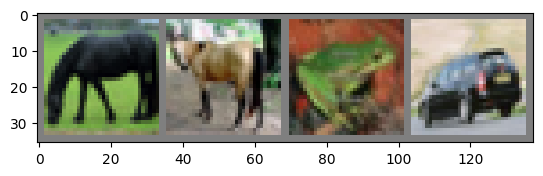

horse horse frog  car  


In [4]:
def imshow(img):
    img = img / 2 + 0.5     #unnormalizing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

#showing images along with their labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
class CIFAR10Net(nn.Module):
  def __init__(self):

    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = CIFAR10Net().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
torch.manual_seed(42)
epochs = 10
for epoch in range(epochs):
  running_loss = 0
  for i, (inputs, labels) in enumerate(trainloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    pred = net(inputs)
    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0
print('Finished Training')

[1,  2000] loss: 2.207
[1,  4000] loss: 1.866
[1,  6000] loss: 1.685
[1,  8000] loss: 1.599
[1, 10000] loss: 1.537
[1, 12000] loss: 1.478
[2,  2000] loss: 1.411
[2,  4000] loss: 1.388
[2,  6000] loss: 1.337
[2,  8000] loss: 1.340
[2, 10000] loss: 1.329
[2, 12000] loss: 1.288
[3,  2000] loss: 1.222
[3,  4000] loss: 1.217
[3,  6000] loss: 1.241
[3,  8000] loss: 1.203
[3, 10000] loss: 1.199
[3, 12000] loss: 1.183
[4,  2000] loss: 1.114
[4,  4000] loss: 1.118
[4,  6000] loss: 1.124
[4,  8000] loss: 1.122
[4, 10000] loss: 1.118
[4, 12000] loss: 1.138
[5,  2000] loss: 1.018
[5,  4000] loss: 1.039
[5,  6000] loss: 1.052
[5,  8000] loss: 1.074
[5, 10000] loss: 1.050
[5, 12000] loss: 1.045
[6,  2000] loss: 0.952
[6,  4000] loss: 0.990
[6,  6000] loss: 1.009
[6,  8000] loss: 0.978
[6, 10000] loss: 0.988
[6, 12000] loss: 1.043
[7,  2000] loss: 0.932
[7,  4000] loss: 0.923
[7,  6000] loss: 0.932
[7,  8000] loss: 0.943
[7, 10000] loss: 0.969
[7, 12000] loss: 0.973
[8,  2000] loss: 0.860
[8,  4000] 

In [10]:
correct = 0
with torch.no_grad():
  for images, labels in testloader:
    pred = net(images)
    _, predicted = torch.max(pred.data, 1)
    correct += (predicted == labels).sum().item()
print(f'{correct} correct predictions out of 10000')
print(f'Accuracy: {correct/100 :.2f} %')

6174 correct predictions out of 10000
Accuracy: 61.74 %


In [11]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
  for images, labels in testloader:
    pred = net(images)
    _, predictions = torch.max(pred, 1)
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname in correct_pred:
  print(f'Accuracy for class: {classname:5s} is {correct_pred[classname] / total_pred[classname] * 100:.2f} %')

Accuracy for class: plane is 57.40 %
Accuracy for class: car   is 75.50 %
Accuracy for class: bird  is 40.80 %
Accuracy for class: cat   is 35.70 %
Accuracy for class: deer  is 51.20 %
Accuracy for class: dog   is 57.60 %
Accuracy for class: frog  is 82.10 %
Accuracy for class: horse is 66.20 %
Accuracy for class: ship  is 77.90 %
Accuracy for class: truck is 73.00 %


This is an implementation of a basic CNN.
It can be made better by using more convolution layers to learn richer features, dropout layers to prevent overfitting, better optimizers and data augmentation to improve generalization. 